In [99]:
import random
import csv
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from math import sqrt, exp

In [35]:
class Customer:
    def __init__(self, t_arrive):
        self.t_arrive = t_arrive # arrival time point
        self.time_e_queue = 0 # queuing time at the entrance
        self.time_shopping = 0 # shopping time
        self.time_shopping_planned = random.gauss(shopping_time_mean, shopping_time_std) # planned shopping time
        self.time_c_queue = 0 # queuing time at the check-out
        self.time_check_out = 0 # service time at the check-out
        self.n_shopping_w = list() # how many people he/she shopping with in the same supermarket
        self.served = 0

        
class Supermarket:
    def __init__(self, area, buffer, counters):
        # customer dynamics
        self.e_queue = list()
        self.shopping = list()
        self.c_queue = list()
        self.history = list()
        
        # properties
        self.area = area
        self.buffer = buffer
        self.counters = counters
        
        # statistics
        self.e_queue_count = [0]
        self.shopping_count = [0]
        self.c_queue_count = [0]

In [181]:
def update_supermarkets(smarkets):
    for smarket in smarkets:

        mu = 1 / service_time
        if len(smarket.c_queue) != 0:
            # select the number of counters finishes serving
            exit_finished = sum(np.random.choice([0, 1], smarket.counters, p = [1 - mu, mu]))  
            exit = min(exit_finished, len(smarket.c_queue))
            if exit >= 1:
                while exit > 0 and len(smarket.c_queue) > 0:
                    smarket.history.append(smarket.c_queue[0])
                    smarket.c_queue.remove(smarket.c_queue[0])
                    exit -= 1

        for customer in smarket.c_queue:
            customer.time_c_queue += 1
            
        # 2. update shopping customers
        for customer in smarket.shopping:
            customer.time_shopping += 1
            customer.n_shopping_w.append(len(smarket.shopping))
            
            if customer.time_shopping >= customer.time_shopping_planned:
                smarket.c_queue.append(customer)
                smarket.shopping.remove(customer)
                
                                
        # 3. update entrance queue
        n_customer = len(smarket.shopping) + len(smarket.c_queue)
        while n_customer  < smarket.buffer and len(smarket.e_queue) >= 1:
            smarket.e_queue[0].served = 1 # the customer will be served once entering the supermarket
            smarket.shopping.append(smarket.e_queue[0])
            smarket.e_queue.remove(smarket.e_queue[0])
            n_customer = len(smarket.shopping) + len(smarket.c_queue)
            
        for customer in smarket.e_queue:
            customer.time_e_queue += 1
            

        # 4. statistics
        smarket.e_queue_count.append(len(smarket.e_queue))
        smarket.shopping_count.append(len(smarket.shopping))
        smarket.c_queue_count.append(len(smarket.c_queue))
        
    return smarkets

def insert_customer(smarket, new_customer):
    
    smarket.e_queue.append(new_customer)
    
    return smarket

def customer_left(smarkets):
    # check if there is any customer left in the shopping area and checkout counters
    customers_left = 0
    for smarket in smarkets:
        customers_left += len(smarket.shopping) + len(smarket.c_queue)
    return customers_left

def clear_queue(smarkets):
    # move the queue at entrance to the history list and clear the queue after office hour
    for smarket in smarkets:
        smarket.history += smarket.e_queue
        smarket.e_queue = list()
    return smarkets

def shortest_e_queue(smarkets):
    e_queue_min = 100000
    ind = random.choice(list(range(len(smarkets))))
    
    for i in range(len(smarkets)):
        if len(smarkets[i].e_queue) < e_queue_min:
            e_queue_min = len(smarkets[i].e_queue)
            ind = i
            
    return ind

In [221]:
def kd(d):
    if d <= d_threshold:
        kd = 1 - (d / d_threshold)
    else:
        kd = 0
    return kd

def kt(t):
    if t <= t_threshold:
        kt = t / t_threshold
    else:
        kt = 1
    return kt

def cal_ds(area, customer):
    
    space_area = area / 2 # actual area people can shopping
    k = 0.5 # a factor to adjust people's interaction within the supermarket - to reduce contact distance
    
    if len(customer.n_shopping_w) != 0:
        ave_n_shopping_w = sum(customer.n_shopping_w) / len(customer.n_shopping_w)
    else:
        ave_n_shopping_w = 0

    if ave_n_shopping_w != 0:
        ds = k * sqrt(space_area / ave_n_shopping_w)  # everyone in a square
    else:
        ds = sqrt(space_area)
    return ds

def cal_lambd(ratio, Ns):
    households = ratio * Ns
    visits = households / 7 # number of visits to supermarkets a day, each households visit the supermarket once a week
    lambd = visits / time_span # number of visits per minute (7 hr a day (9 - 16), and 60 minutes per hour)
    
    return lambd

def cal_ps(dq, tq, ds, ts, dc, tc):
    pq = kd(dq) * kt(tq) * p_outdoor # being infected at the entrance
    ps = kd(ds) * kt(ts) * p_indoor # being infected during shopping
    pc = kd(dc) * kt(tc) * p_indoor # be infected during check-out
    p_infected = 1 - (1 - pq) * (1 - ps) * (1 - pc)
    
    return p_infected, pq, ps, pc

def cal_objective(smarkets):
    sum_p_infected = 0
    sum_pq = 0
    sum_ps = 0
    sum_pc = 0
    sum_hungry = 0
    n_customer = 0
    n_customer_shopping = 0
    i = 0
    for smarket in smarkets:
        n_customer += len(smarket.history)
        for customer in smarket.history:
            tq = customer.time_e_queue
            ds = cal_ds(smarket.area, customer)
            ts = customer.time_shopping
            tc = customer.time_c_queue + customer.time_check_out
            
            if ts > 0:
                n_customer_shopping += 1
                
            p_infected, pq, ps, pc = cal_ps(dq, tq, ds, ts, dc, tc)
            sum_p_infected += p_infected
            sum_pq += pq
            sum_ps += ps
            sum_pc += pc
            
            sum_hungry += 1 - customer.served # if served, not hungry
            
           
    pqm = sum_pq / n_customer
    psm = sum_ps / n_customer_shopping
    pcm = sum_pc / n_customer_shopping
    I_contact = sum_p_infected / n_customer
    I_hungry = sum_hungry / n_customer
    
    alpha = 0.5
    objective = alpha * I_contact + (1 - alpha) * I_hungry
    #objective = I_contact + I_hungry
    
    return objective, I_contact, I_hungry, pqm, psm, pcm

### Output pictures

ratio_h_s:  500
ratio_h_s:  2000
ratio_h_s:  5000
ratio_h_s:  10000


Text(0, 0.5, 'Ic Contact Index')

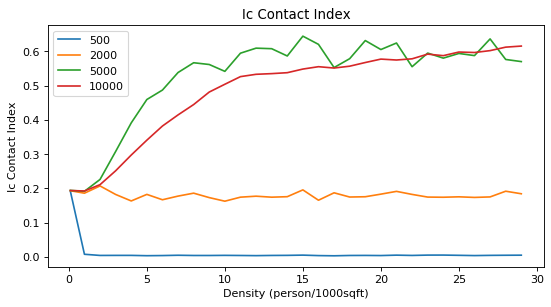

In [223]:
time_span = 420
ratio_h_s = [500, 2000, 5000, 10000] # local households and supermarket ratio
service_time = 3 # 3 minutes service time at the counter
area = 1000 # 1000 m2
#densities = list(range(1, 30)) # maximum allowed density of customers pop / 100m^2
densities = [0.1] + list(1 * np.array(range(1, 30)))
counters = 5
Ns = 10 # Number of supermarkets
shopping_time_mean = 30 # 30 min
shopping_time_std = 5 # 5 min
p_outdoor = 0.5 # base-line prob for being inside
p_indoor = 1 # base-line prob for being outside
dq = 1.8 # everyone stands 1.8m (6 feet) away from each other at the entrance 
dc = 1 # everyone stands 1m away from each other at the chect-out
d_threshold = 3 # more than 3m (10 feet), chance of getting infected is 0
t_threshold = 30 # more than 30 min, the influence of time is a constant 1

fig = plt.figure(figsize=(8, 4), dpi=80)
rows = 1
cols = 1
gs = gridspec.GridSpec(rows, cols)
axs = list()
for r in range(rows):
    for c in range(cols):
        axs.append(fig.add_subplot(gs[r, c]))
legends = list()

for ratio in ratio_h_s:
    lambd = cal_lambd(ratio, Ns)
    
    objective_list = list()
    I_contact_list = list()
    I_hungry_list = list()
    pqm_list = list()
    psm_list = list()
    pcm_list = list()
    
    for density in densities:

        t = 0
        buffer = int(area * density / 100) # allowed number of customers
        smarkets = list()
        cleared = 0 # check if the smarket is cleared after opening hours
        customers = [0] # used to check to
        
        for i in range(Ns):
            smarkets.append(Supermarket(area, buffer, counters))

        while (t < time_span or customer_left(smarkets)): # while open time and still customer not served
            t += 1

            if t < time_span: # stop accepting customers after a certain time
                n = np.random.poisson(lambd, 1)[0]
                customers.append(customers[-1] + n)
                
                for j in range(n):
                    new_customer = Customer(t)

                    # choose supermarkets
                    # strategy 1: random choose
                    ns = random.choice(list(range(Ns)))
                    # strategy 2: choose the one with shortest e_queue
                    #ns = shortest_e_queue(smarkets)
                    
                    # insert customer
                    smarkets[ns] = insert_customer(smarkets[ns], new_customer)
            
            if t > time_span:
                customers.append(customers[-1])
                if not cleared:
                    # any customer waiting in entrance queue will not be allowed in
                    smarkets = clear_queue(smarkets)
                    cleared = 1
    
            # 3. update supermarkets
            smarkets = update_supermarkets(smarkets)

        #plot_smarket(smarkets[0])
        #average_ps.append(cal_average_p(smarkets))
        objective, I_contact, I_hungry, pqm, psm, pcm = cal_objective(smarkets)

        objective_list.append(objective)
        I_contact_list.append(I_contact)
        I_hungry_list.append(I_hungry)
        pqm_list.append(pqm)
        psm_list.append(psm)
        pcm_list.append(pcm)
    
#         title = 'ratio_h_s: ' + str(ratio) + ', ' + 'density: ' + str(density)
#         plot_smarket(smarkets[0], title)
        
#         print('Total arrival:', customers[-1])
#         sum_customers = 0
#         for m in smarkets:
#             sum_customers += (len(m.history))
#         print('Sum smarkets customers: ', sum_customers)
        
    print('ratio_h_s: ', ratio)
    #ys = [ objective_list, I_contact_list,I_hungry_list, pqm_list, psm_list, pcm_list]
    ys = [I_contact_list]
    #titles = ['objective', 'I_contact', 'I_hungry', 'pqm', 'psm', 'pcm']
    titles = ['Ic Contact Index']
    legends.append(str(ratio))
    for i in range(len(axs)):
        axs[i].plot(densities, ys[i])
        axs[i].set_title(titles[i])
axs[0].legend(legends)
axs[0].set_xlabel('Density (person/1000sqft)')
axs[0].set_ylabel('Ic Contact Index')

### Output for analysis

In [143]:
df = pd.DataFrame(pd.Series(densities), columns = ['density'])
cols = ['objective', 'I_contact', 'I_hungry','pqm','psm','pcm']
data_list = [objective_list, I_contact_list, I_hungry_list\
             ,pqm_list, psm_list, pcm_list]
for i in range(len(cols)):
    df[cols[i]] = pd.Series(data_list[i])
df.to_csv('temp2.csv')

### Plot dynamics of a single smarket

ratio_h_s:  3000


Text(0.5, 0, 'Customer density (person/1000sqft)')

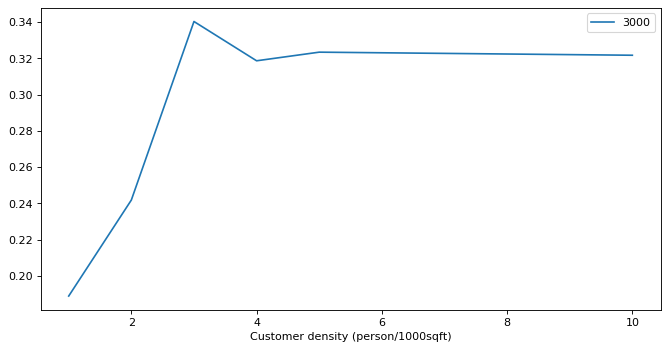

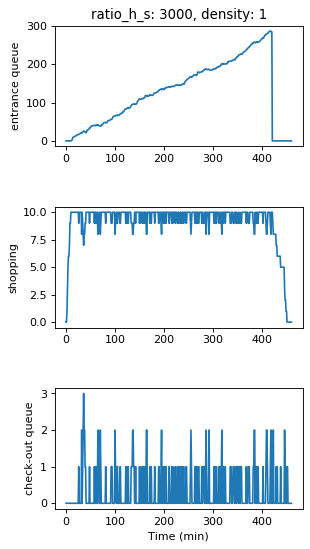

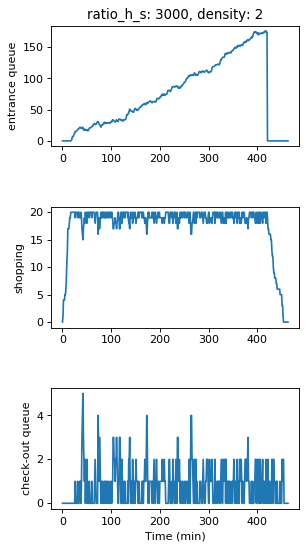

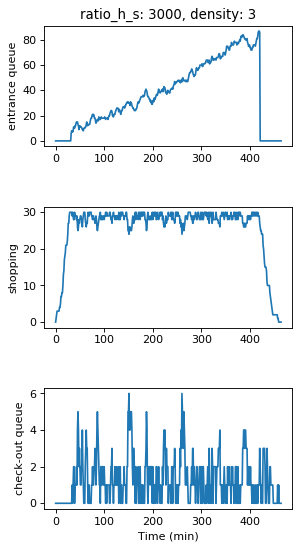

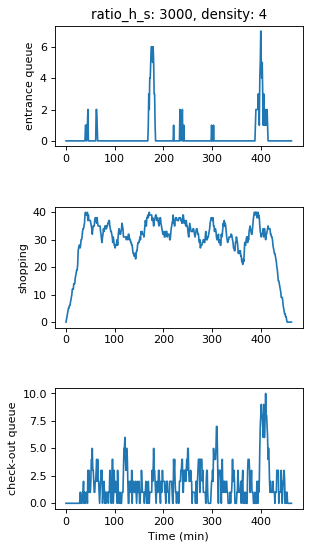

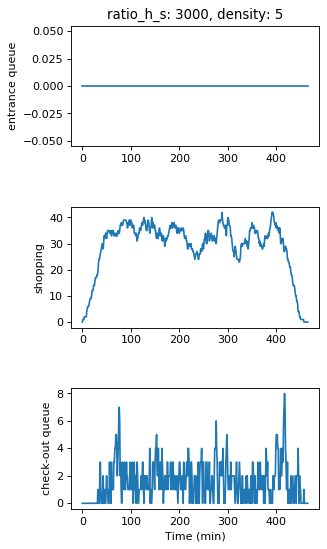

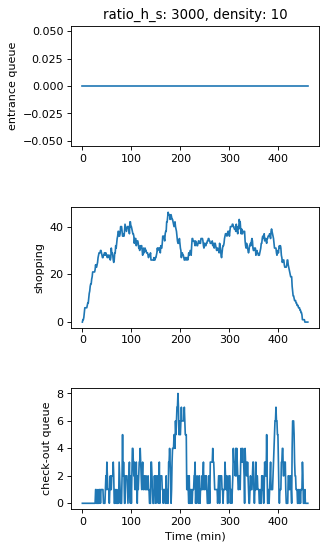

In [211]:
time_span = 420
#households = [20000, 30000, 32000, 34000, 40000] # local household numbers
ratio_h_s = [3000] # local households and supermarket ratio
service_time = 3 # 3 minutes service time at the counter
area = 1000 # 1000 m2
#densities = list(range(1, 30)) # maximum allowed density of customers pop / 100m^2
densities = [1, 2, 3, 4, 5, 10]
counters = 5
Ns = 10 # Number of supermarkets
shopping_time_mean = 30 # 30 min
shopping_time_std = 5 # 5 min
p0 = 0.5 # base-line prob for being inside
p1 = 1   # base-line prob for being outside
dq = 1.8 # everyone stands 1.8m (6 feet) away from each other at the entrance 
dc = 1 # everyone stands 1m away from each other at the chect-out
d_threshold = 3 # more than 3m (10 feet), chance of getting infected is 0
t_threshold = 30 # more than 30 min, the influence of time is a constant 1

fig = plt.figure(figsize=(10, 5), dpi=80)
ax = fig.add_subplot(111)
legends = list()

for ratio in ratio_h_s:
    lambd = cal_lambd(ratio, Ns)
    average_ps = list()
    Iqms = list()
    Isms = list()
    Icms = list()
    
    for density in densities:

        t = 0
        buffer = int(area * density / 100)
        smarkets = list()
        cleared = 0
        customers = [0]
        
        for i in range(Ns):
            smarkets.append(Supermarket(area, buffer, counters))

        while (t < time_span or customer_left(smarkets)): # while open time and still customer not served
            t += 1
            
            if t < time_span: # stop accepting customers after a certain time
                n = np.random.poisson(lambd, 1)[0]
                
                for j in range(n):
                    new_customer = Customer(t)
                    
                    # choose supermarkets
                    ns = random.choice(list(range(Ns)))

                    # insert customer
                    smarkets[ns] = insert_customer(smarkets[ns], new_customer)
            
            if t > time_span:
                customers.append(customers[-1])
                if not cleared:
                    # any customer waiting in entrance queue will not be allowed in
                    smarkets = clear_queue(smarkets)
                    cleared = 1
    
            # 3. update supermarkets
            smarkets = update_supermarkets(smarkets)

        #plot_smarket(smarkets[0])
        #average_ps.append(cal_average_p(smarkets))
        average_p, Iqm, Ism, Icm = cal_average_p_beta(smarkets)

        average_ps.append(average_p)
        Iqms.append(Iqm)
        Isms.append(Ism)
        Icms.append(Icm)
        
        title = 'ratio_h_s: ' + str(ratio) + ', ' + 'density: ' + str(density)
        plot_smarket(smarkets[0], title)
        
    print('ratio_h_s: ', ratio)
    ax.plot(densities, average_ps)
    legends.append(str(ratio))

ax.legend(legends)
ax.set_xlabel('Customer density (person/1000sqft)')

plt.hist(average_ps, 10)

In [18]:
def print_customer(customer):
    print("t_arrive: ", customer.t_arrive)
    print("time_e_queue: ", customer.time_e_queue)
    print("time_shopping: ", customer.time_shopping)
    print("time_shopping_planned: ", customer.time_shopping_planned)
    print("time_c_queue: ", customer.time_c_queue)
    print("time_check_out: ", customer.time_check_out)
    print("n_shopping_w: ", customer.n_shopping_w)
    print("ave_n_shopping_w: ", customer.ave_n_shopping_w)
    
def print_smarket(smarket):
    
    # 1. print entrance queue
    print("Entrance queue: ", len(smarket.e_queue))
    for customer in smarket.e_queue:
        print_customer(customer)
    print("--------------------")
    
    print("Shopping: ", len(smarket.shopping))
    for customer in smarket.shopping:
        print_customer(customer)
    print("--------------------")
    
    print("Check-out queue: ", len(smarket.c_queue))
    for customer in smarket.c_queue:
        print_customer(customer)
    print("**************************************")
    print(" ")
    print(" ")
    
def print_smarket_history(smarket):
    print("History: ", len(smarket.history))
    for customer in smarket.history:
        print_customer(customer)
        print("--------------------")
        
def plot_smarket(smarket, title):
    time = list(range(t + 1))
    y = [smarket.e_queue_count, smarket.shopping_count, smarket.c_queue_count,]
    y_label = ['entrance queue', 'shopping', 'check-out queue']
    
    fig = plt.figure(figsize=(4, 8), dpi=80)
    gs1 = gridspec.GridSpec(len(y), 1)
    gs1.update(wspace=0.1, hspace=0.5)
    axs = list()
    lines = list()
    txts = list()
    for i in range(len(y)):
        ax = axs.append(fig.add_subplot(gs1[i]))
        line, = axs[i].plot(time, y[i])
        lines.append(line)
        
        axs[i].set_ylabel(y_label[i])
        
    axs[0].set_title(title)
    axs[2].set_xlabel('Time (min)')

def plot_ps(x, ys, legend):
    y_label = ['p_not_infected', 'Iq', 'Is', 'Ic']
    
    fig = plt.figure(figsize=(6, 8), dpi=80)
    gs1 = gridspec.GridSpec(len(ys), 1)
    gs1.update(wspace=0.1, hspace=0.5)
    axs = list()
    lines = list()
    txts = list()
    for i in range(len(ys)):
        ax = axs.append(fig.add_subplot(gs1[i]))
        line, = axs[i].plot(x, ys[i])
        lines.append(line)
        
        axs[i].set_ylabel(y_label[i])
        axs[i].legend(legend)

    axs[-1].set_xlabel('Density person/100m^2')

def plot_ps2(x, ys, legend):
    y_label = ['p_infected', 'Iq', 'Is', 'Ic']
    
    fig = plt.figure(figsize=(8, 3), dpi=80)
    ax = fig.add_subplot(111)
    ax.plot(x, ys[0])
    ax.set_ylabel(y_label[0])
    ax.legend(legend)

    ax.set_xlabel('Density person/100m^2')

In [241]:
# for smarket in smarkets:
#     print_smarket(smarket)

In [242]:
# for smarket in smarkets:
#     print_smarket_history(smarket)
#     print("**************************************")
#     print(" ")
#     print(" ")